import of lib


In [227]:
import numpy as np 
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_breast_cancer 
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn .neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score , classification_report , roc_auc_score , roc_curve
import matplotlib.pyplot as plt 
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler

load data 

In [228]:
df = pd.read_csv("star_classification.csv")

Read and explore the data 


In [229]:
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [230]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [231]:
df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


on remarque qu'on a des valeur 9999 qui ne reflaire pas true values 


In [232]:
#df.replace(-9999, np.nan, inplace=True)

In [233]:
print(df.isna().sum())

obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64


on garde pas tous les colonnes , on rage seulement les colonnes qui fournis des infos intresting 

In [234]:
columns_to_drop = [
    'obj_ID',
    'run_ID',
    'rerun_ID',
    'field_ID',
    'spec_obj_ID',
    'plate',
    'MJD',
    'fiber_ID',
    'cam_col'
]
df.drop(columns=columns_to_drop, axis=1, inplace=True)

In [235]:
df.dropna(inplace=True)

In [236]:
df.shape

(100000, 9)

In [237]:
df['class'].unique()

array(['GALAXY', 'QSO', 'STAR'], dtype=object)

In [238]:
df.sort_values("class")

,alpha,delta,u,g,r,i,z,class,redshift
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY,0.634794
58230,142.047959,51.231393,21.97755,21.53166,21.32114,20.86099,20.36108,GALAXY,0.931503
58228,140.841355,50.692416,23.41943,22.03784,21.14735,20.79810,20.37284,GALAXY,0.255631
58227,223.984760,-1.841606,22.18194,21.53138,20.52969,19.49590,18.90042,GALAXY,0.509081
58226,216.754539,-1.946554,25.55715,20.90226,19.11438,18.38413,17.95209,GALAXY,0.417001
...,...,...,...,...,...,...,...,...,...
46329,251.580659,38.559354,23.41423,21.04343,19.71153,19.26199,19.02872,STAR,-0.000387
46330,237.215497,25.986546,17.54356,16.42303,15.91468,15.71449,15.61154,STAR,-0.000482
46331,109.885032,0.048816,22.43742,19.55231,18.46435,18.01848,17.74893,STAR,0.000177
75082,158.030632,-1.411047,21.96090,20.85199,20.60211,20.44812,20.24777,STAR,0.000930


In [239]:
df['class'].value_counts()

class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64

Visualization 

<Axes: xlabel='class', ylabel='count'>

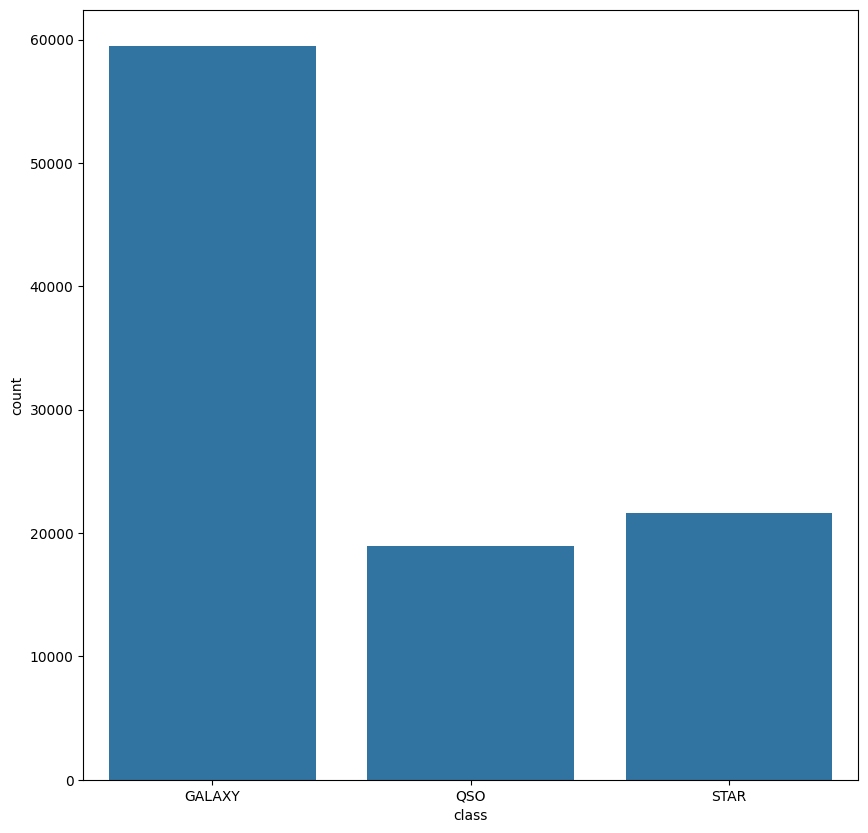

In [240]:
plt.figure(figsize=(10,10))
sns.countplot(data=df,x="class")

([<matplotlib.patches.Wedge at 0x2c648c107d0>,
 [Text(-0.3216272173789337, 1.051929623616088, 'GALAXY'),
  Text(-0.3239728375169962, -1.0512095892595283, 'STAR'),
  Text(0.9105456051052268, -0.6171763937672573, 'QSO')],
 [Text(-0.17543302766123656, 0.5737797946996842, '59%'),
  Text(-0.17671245682745243, -0.5733870486870154, '22%'),
  Text(0.49666123914830546, -0.3366416693275948, '19%')])

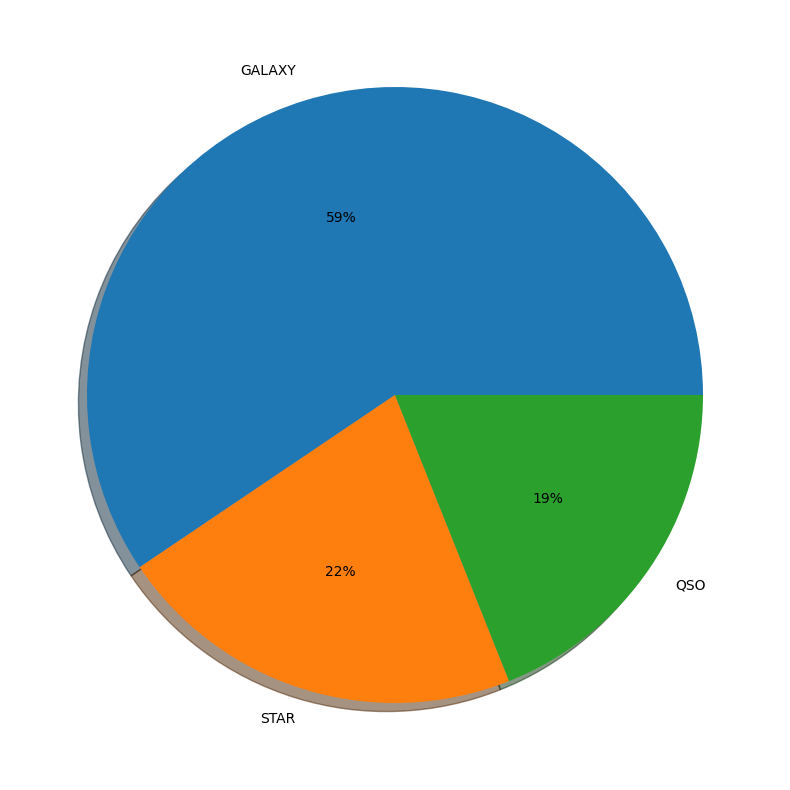

In [241]:
plt.figure(figsize=(10,10))
plt.pie(x=df['class'].value_counts(),labels=["GALAXY","STAR","QSO"],autopct="%1.f%%",shadow=True)

preprocessing & correlation matrix & feature selection

In [242]:
from sklearn.calibration import LabelEncoder
encoder=LabelEncoder()
df['class']=encoder.fit_transform(df['class'])

In [255]:
def plot(column,df):
    for i in range(3):
        sns.kdeplot(data=df[df["class"] == i][column], label = encoder.inverse_transform([i]), fill = True)
    sns.kdeplot(data=df[column],label = ["All"], fill = True)
    plt.legend();
    
def log_plot(column):
    for i in range(3):
        sns.kdeplot(data=np.log(df[df["class"] == i][column]), label = encoder.inverse_transform([i]), fill = True)
    sns.kdeplot(data=np.log(df[column]),label = ["All"], fill = True)
    plt.legend()

Text(0.5, 1.0, ' stellar correlation matrix')

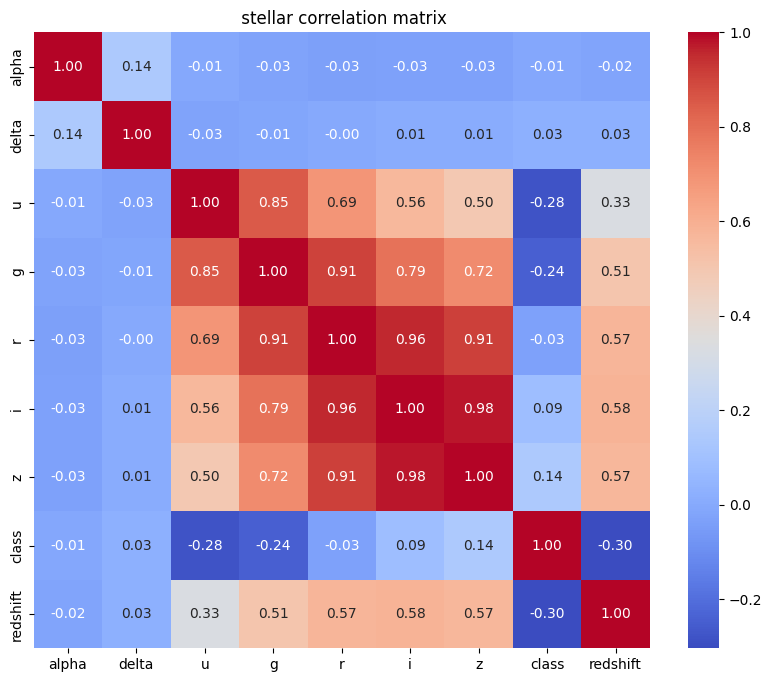

In [244]:
corr_matt=df.corr(method="spearman")
plt.figure(figsize=(10,8))
sns.heatmap(corr_matt,annot=True,fmt="0.2f",cmap="coolwarm",square=True)
plt.title(" stellar correlation matrix")

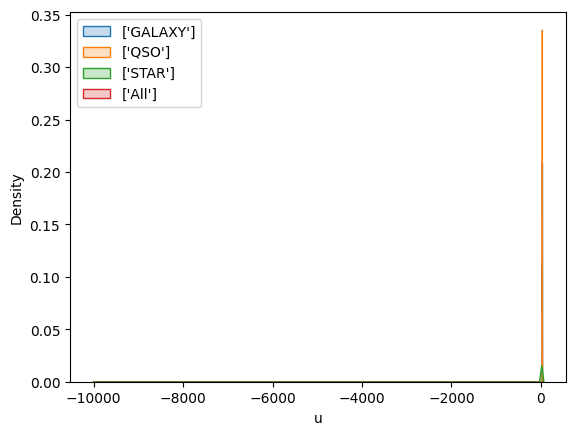

In [256]:
plot('u',df)

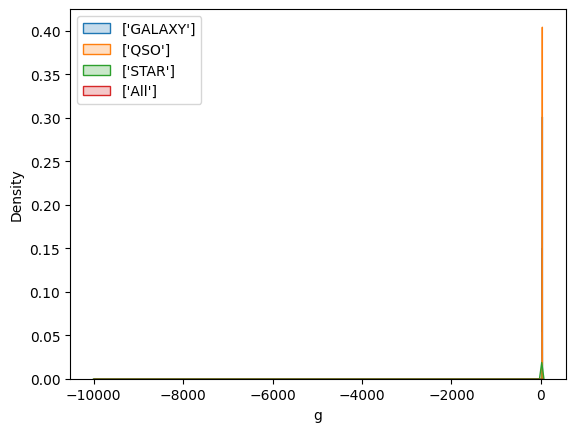

In [246]:
plot('g')

In [247]:
import pandas as pd
import numpy as np

def remove_outliers_iqr(df, cols=None, visualize=False):
    """
    Returns a copy of df with outliers removed using IQR method.
    Optionally specify columns; if none, all numeric columns are used.
    """
    df_clean = df.copy()
    original_shape = df.shape

    if cols is None:
        cols = df.select_dtypes(include='number').columns

    for col in cols:
        q1 = df_clean[col].quantile(0.25)
        q3 = df_clean[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr

        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]

    removed = original_shape[0] - df_clean.shape[0]
    print(f"Outliers removed: {removed} rows")

    return df_clean


In [248]:
# Remove outliers from the whole DataFrame (safe version)
clean_star = remove_outliers_iqr(df)

# Remove outliers only from specific columns
#clean_star = remove_outliers_iqr(star, cols=['u', 'g', 'r', 'i', 'z'])

# View how many rows were removed
print(f"After cleaning: {clean_star.shape}")


Outliers removed: 9400 rows
After cleaning: (90600, 9)


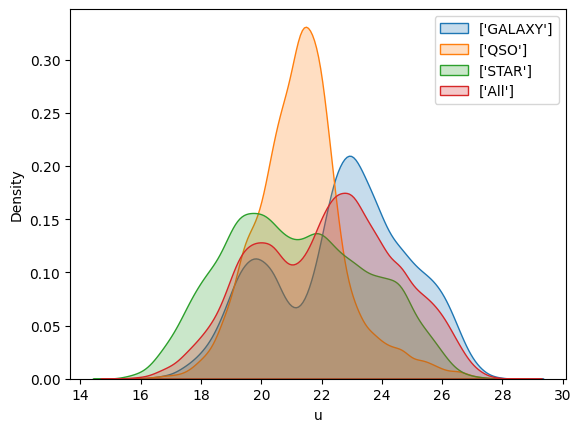

In [257]:
plot('u',clean_star)

In [250]:
x=df.drop("class",axis=1)
y=df['class']

In [251]:
scaler=StandardScaler()
x_scaler=scaler.fit_transform(x)

Train/Test split

In [252]:
x_train,x_test,y_train,y_test=train_test_split(x_scaler,y,test_size=0.3,random_state=42)

In [253]:
x_train.shape


(70000, 8)

In [254]:
x_test.shape

(30000, 8)